# FMS #62

- Discussing current status of Hall Probe tests
- First summarize what tests have been completed
- Highlight most recent test and what we've learned
- Discuss $|B|$ equation
- Plans for post-Thanksgiving

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import re
import csv
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser

import operator
from scipy import stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
init_notebook_mode(True)

from hallprobecalib import hpc_ext_path
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo,py_profile

In [4]:
plotdir = '/home/ckampa/Dropbox/research/deliverables/presentations/fms/11-26-19 Hall Probe Stability 3/figures/'

In [5]:
datadir = "/home/ckampa/Dropbox/LogFiles/"
pkldir = hpc_ext_path+"datafiles/magnet_stability/pkl/"

In [6]:
df = pd.read_pickle(pkldir+"magnet_stability_all.pkl")

In [7]:
df.head()

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,Zaber_Meas_MicroStep_X,Zaber_Meas_Encoder_X,Zaber_Meas_MicroStep_Y,Zaber_Meas_Encoder_Y,Zaber_Meas_MicroStep_Z,Zaber_Meas_Encoder_Z,run,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-07-16 10:12:40,7/16/2019 10:12:40 AM,256.069238,33.803850,55.239761,52.688934,31.030971,34.043785,32.280407,38.443527,29.436894,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,10,0.0,0.000000,0.000000
2019-07-16 10:13:40,7/16/2019 10:13:40 AM,256.069310,33.803700,55.233868,52.673191,31.029926,34.037178,32.402508,38.393867,29.435436,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,10,60.0,0.016667,0.000694
2019-07-16 10:14:40,7/16/2019 10:14:40 AM,256.069224,33.803700,55.229145,52.680092,31.013575,34.047707,32.277966,38.459206,29.444553,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,10,120.0,0.033333,0.001389
2019-07-16 10:15:40,7/16/2019 10:15:40 AM,256.069285,33.803833,55.199894,52.724766,31.009970,34.055397,32.232929,38.468384,29.450718,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,10,180.0,0.050000,0.002083
2019-07-16 10:16:40,7/16/2019 10:16:40 AM,256.069277,33.803800,55.242519,52.758240,31.042023,34.066185,32.286911,38.431835,29.435515,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,10,240.0,0.066667,0.002778


In [8]:
len(df)

67694

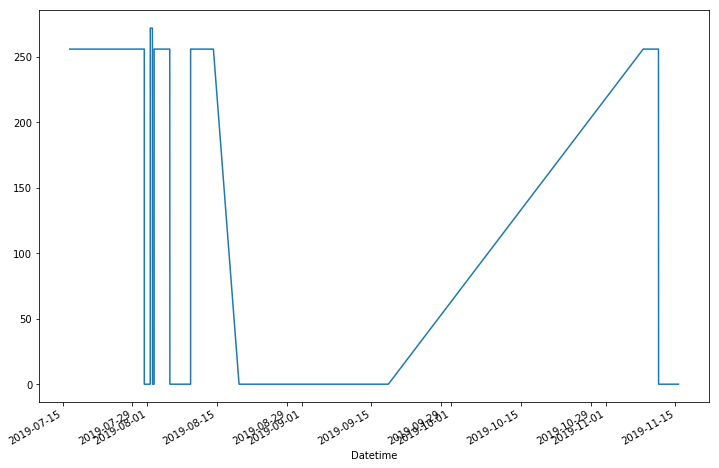

In [9]:
df["Magnet Current [A]"].plot()

### Decoding caldat.dat

In [10]:
# file
calfile = hpc_ext_path + "probeinfo/caldat.dat"

In [40]:
with open(calfile, "rb") as f:
    content = f.readlines()

# remove whitespace
#content = [x.strip() for x in content]

In [41]:
c = content[0]
c

b'\x0e\x00\x00\x00\x05\x01\x8d\x00\x00\x00\rZ=:\xac\x03\x00\x00\x0e\x00\x00\x00\xac\x03\x00\x009\x01\x00\x00i\x02\x00\x00\x00\x00\x00\x00\xf7\x91\x02\x10J\x00\xbcKh\x9f\x00\xbd\x01) \x00?\x85\xa0\x1a\xb4 \xe4\xd0\xb8\x8a\xb9\xc2\x11\x00J\x00\xb9\xfe\x9b\xf8\x007\xc9\\{\x00?\x80\x0f \xba\x9c-\x12?\x007\x9c\x11\x00J\x00={\x9b\xb6\x00\xbd\xe68"\x00?\x86\x86\xa4\xb8\x88\xb7\x12;\xd9\xd2\\\x11\x00:\x00\xbeE\xf5h\x00?\x98\xbe\xad7\xc0\x0c\xde\xbaj)\xba\x11\x00*\x00?\x80\x00\x00\xb4\x8a\xb9_9\x0f\x02\xc5\x11\x00\x19\x00\x11\x00*\x00?\x80\x00\x005\xa8\xf6W7Mb\xaa\x11?\xba\xa0|:\x00\xbf\x18Q\x8e\x00?\xcc(\xc73\xdco\x178\xc1"\xbb\x11>\x19\x80zJ\x00\xbc\x85\xe4\xc4\x00<\xdd\x8f>\x00?}B\xac\xb8\xd2\x92\xe2;\x18%\x08\x11\xbd 8v:\x00\xbd\xf6\x9d8\x00?\x8fi\xd3\xb7\xb42\n'

In [42]:
import binascii

In [53]:
binascii.unhexlify(binascii.b2a_hex(c))

b'\x0e\x00\x00\x00\x05\x01\x8d\x00\x00\x00\rZ=:\xac\x03\x00\x00\x0e\x00\x00\x00\xac\x03\x00\x009\x01\x00\x00i\x02\x00\x00\x00\x00\x00\x00\xf7\x91\x02\x10J\x00\xbcKh\x9f\x00\xbd\x01) \x00?\x85\xa0\x1a\xb4 \xe4\xd0\xb8\x8a\xb9\xc2\x11\x00J\x00\xb9\xfe\x9b\xf8\x007\xc9\\{\x00?\x80\x0f \xba\x9c-\x12?\x007\x9c\x11\x00J\x00={\x9b\xb6\x00\xbd\xe68"\x00?\x86\x86\xa4\xb8\x88\xb7\x12;\xd9\xd2\\\x11\x00:\x00\xbeE\xf5h\x00?\x98\xbe\xad7\xc0\x0c\xde\xbaj)\xba\x11\x00*\x00?\x80\x00\x00\xb4\x8a\xb9_9\x0f\x02\xc5\x11\x00\x19\x00\x11\x00*\x00?\x80\x00\x005\xa8\xf6W7Mb\xaa\x11?\xba\xa0|:\x00\xbf\x18Q\x8e\x00?\xcc(\xc73\xdco\x178\xc1"\xbb\x11>\x19\x80zJ\x00\xbc\x85\xe4\xc4\x00<\xdd\x8f>\x00?}B\xac\xb8\xd2\x92\xe2;\x18%\x08\x11\xbd 8v:\x00\xbd\xf6\x9d8\x00?\x8fi\xd3\xb7\xb42\n'

In [37]:
codecs.decode(c, "cp")

'\x0e\x00\x00\x00\x05\x01Ź\x00\x00\x00\rZ=:¼\x03\x00\x00\x0e\x00\x00\x00¼\x03\x00\x009\x01\x00\x00i\x02\x00\x00\x00\x00\x00\x00„æ\x02\x10J\x00╝Kh¤\x00Į\x01) \x00?ģĀ\x1a┤ õąĖŖ╣┬\x11\x00J\x00╣■ø°\x007╔\\{\x00?Ć\x0f ║£-\x12?\x007£\x11\x00J\x00={øČ\x00Įµ8"\x00?ååżĖłĘ\x12;┘ę\\\x11\x00:\x00ŠE§h\x00?śŠŁ7└\x0c▐║j)║\x11\x00*\x00?Ć\x00\x00┤Ŗ╣_9\x0f\x02┼\x11\x00\x19\x00\x11\x00*\x00?Ć\x00\x005©÷W7Mb¬\x11?║Ā|:\x00┐\x18QÄ\x00?╠(Ū3▄o\x178┴"╗\x11>\x19ĆzJ\x00╝ģõ─\x00<▌Å>\x00?}B¼ĖęÆŌ;\x18%\x08\x11Į 8v:\x00Į÷Ø8\x00?ÅiėĘ┤2'

In [29]:
c.decode('base64','strict')

LookupError: 'base64' is not a text encoding; use codecs.decode() to handle arbitrary codecs

In [12]:
import codecs

In [13]:
words = {}

In [17]:
with codecs.open(calfile, "r", "utf8") as f:
    for line in f:
        if line.strip():
            key, value = line.strip().split(':')
            words[key] = value

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8d in position 6: invalid start byte